# Next 3 minutes (approx.) of your presentation -- Set The Stage
Present your Exploratory Data Analysis and some initial data-driven Insights from the dataset.
You MAY also mention how you are planning to set up the Analysis / ML problem for this case.
You MUST mention how you collected / curated / cleaned / prepared the data for this problem.
Did you only use tools and techniques learned in this course? What ELSE did you learn / try?

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
listings = pd.read_csv('datasets/listings_with_nlp.csv')

## Type Conversion for numeric variables (object to numeric)

In [4]:
listings['price'] = listings['price'].str.replace('[\$,]', '', regex=True).astype(float)

# convert host_response_rate to float and replace "N/A" values with mean
col_float = pd.to_numeric(listings['host_response_rate'].str.replace('%', ''), errors='coerce')
mean = col_float.mean()
col_float.fillna(mean, inplace=True)
listings['host_response_rate'] = col_float

# convert host_acceptance_rate to float and replace "N/A" values with mean
col_float = pd.to_numeric(listings['host_acceptance_rate'].str.replace('%', ''), errors='coerce')
mean = col_float.mean()
col_float.fillna(mean, inplace=True)
listings['host_acceptance_rate'] = col_float

# apply the function to the 'amenities' column and add a new column to the DataFrame
def get_amenities_count(amenities_list):
    return len(amenities_list.split(','))
listings['amenities_count'] = listings['amenities'].apply(get_amenities_count)

## Remove outliers

In [5]:
# for col in listings.columns:
#     print(f"{col}: {listings[col].dtype}")

In [6]:
columns_to_remove_outliers_from = ['price', 
                                   # 'host_response_rate', 'host_acceptance_rate',
                                   # 'host_listings_count', 'host_total_listings_count', 
                                   # 'accommodates', 'bedrooms', 'beds',
                                   'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
                                   'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
                                   'availability_30', 'availability_60', 'availability_90', 'availability_365', 
                                   # 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
                                   # 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                                   # 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value',
                                   # 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 
                                   # 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
                                   # 'reviews_per_month', 
                                   'amenities_count']

listings_removed_outliers = listings
for col in columns_to_remove_outliers_from:

    # check if the column contains numerical data
    if pd.api.types.is_numeric_dtype(listings_removed_outliers[col]):
        
        # calculate the first and third quartiles of the column
        q1 = listings_removed_outliers[col].quantile(0.25)
        q3 = listings_removed_outliers[col].quantile(0.75)
        
        # calculate the interquartile range
        iqr = q3 - q1
        
        # create a filter to select only rows within the IQR
        within_iqr = (listings_removed_outliers[col] >= q1 - 1.5 * iqr) & (listings_removed_outliers[col] <= q3 + 1.5 * iqr)
        
        # count and drop rows outside the IQR
        num_removed = len(listings_removed_outliers) - len(listings_removed_outliers[within_iqr])
        listings_removed_outliers = listings_removed_outliers[within_iqr]
        
        # print the number of removals and the column name
        print(f"{num_removed} rows removed from column {col}.")

261 rows removed from column price.
31 rows removed from column minimum_nights.
2 rows removed from column maximum_nights.
2 rows removed from column minimum_minimum_nights.
58 rows removed from column maximum_minimum_nights.
13 rows removed from column minimum_maximum_nights.
0 rows removed from column maximum_maximum_nights.
0 rows removed from column minimum_nights_avg_ntm.
0 rows removed from column maximum_nights_avg_ntm.
0 rows removed from column availability_30.
0 rows removed from column availability_60.
0 rows removed from column availability_90.
0 rows removed from column availability_365.
22 rows removed from column amenities_count.


In [7]:
print(len(columns_to_remove_outliers_from))

14


## Corr Matrix 1 (for Numeric Variables)

In [9]:
numeric_cols = listings_removed_outliers.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = listings_removed_outliers[numeric_cols].corr()
price_corr_abs = corr_matrix['price'].abs().sort_values(ascending=False)

# print the top 8 correlations for price based on absolute values
print("Top 16 correlations for 'price' based on absolute values:")
print(price_corr_abs[1:17])

Top 16 correlations for 'price' based on absolute values:
bedrooms                                        0.451534
calculated_host_listings_count_entire_homes     0.417586
minimum_nights                                  0.380008
maximum_minimum_nights                          0.379487
minimum_nights_avg_ntm                          0.377291
minimum_minimum_nights                          0.375274
host_listings_count                             0.350427
calculated_host_listings_count                  0.328172
host_total_listings_count                       0.321340
host_id                                         0.301036
accommodates                                    0.299032
id                                              0.269678
amenities_count                                 0.254952
calculated_host_listings_count_private_rooms    0.252720
availability_30                                 0.228221
host_acceptance_rate                            0.196580
Name: price, dtype: float64


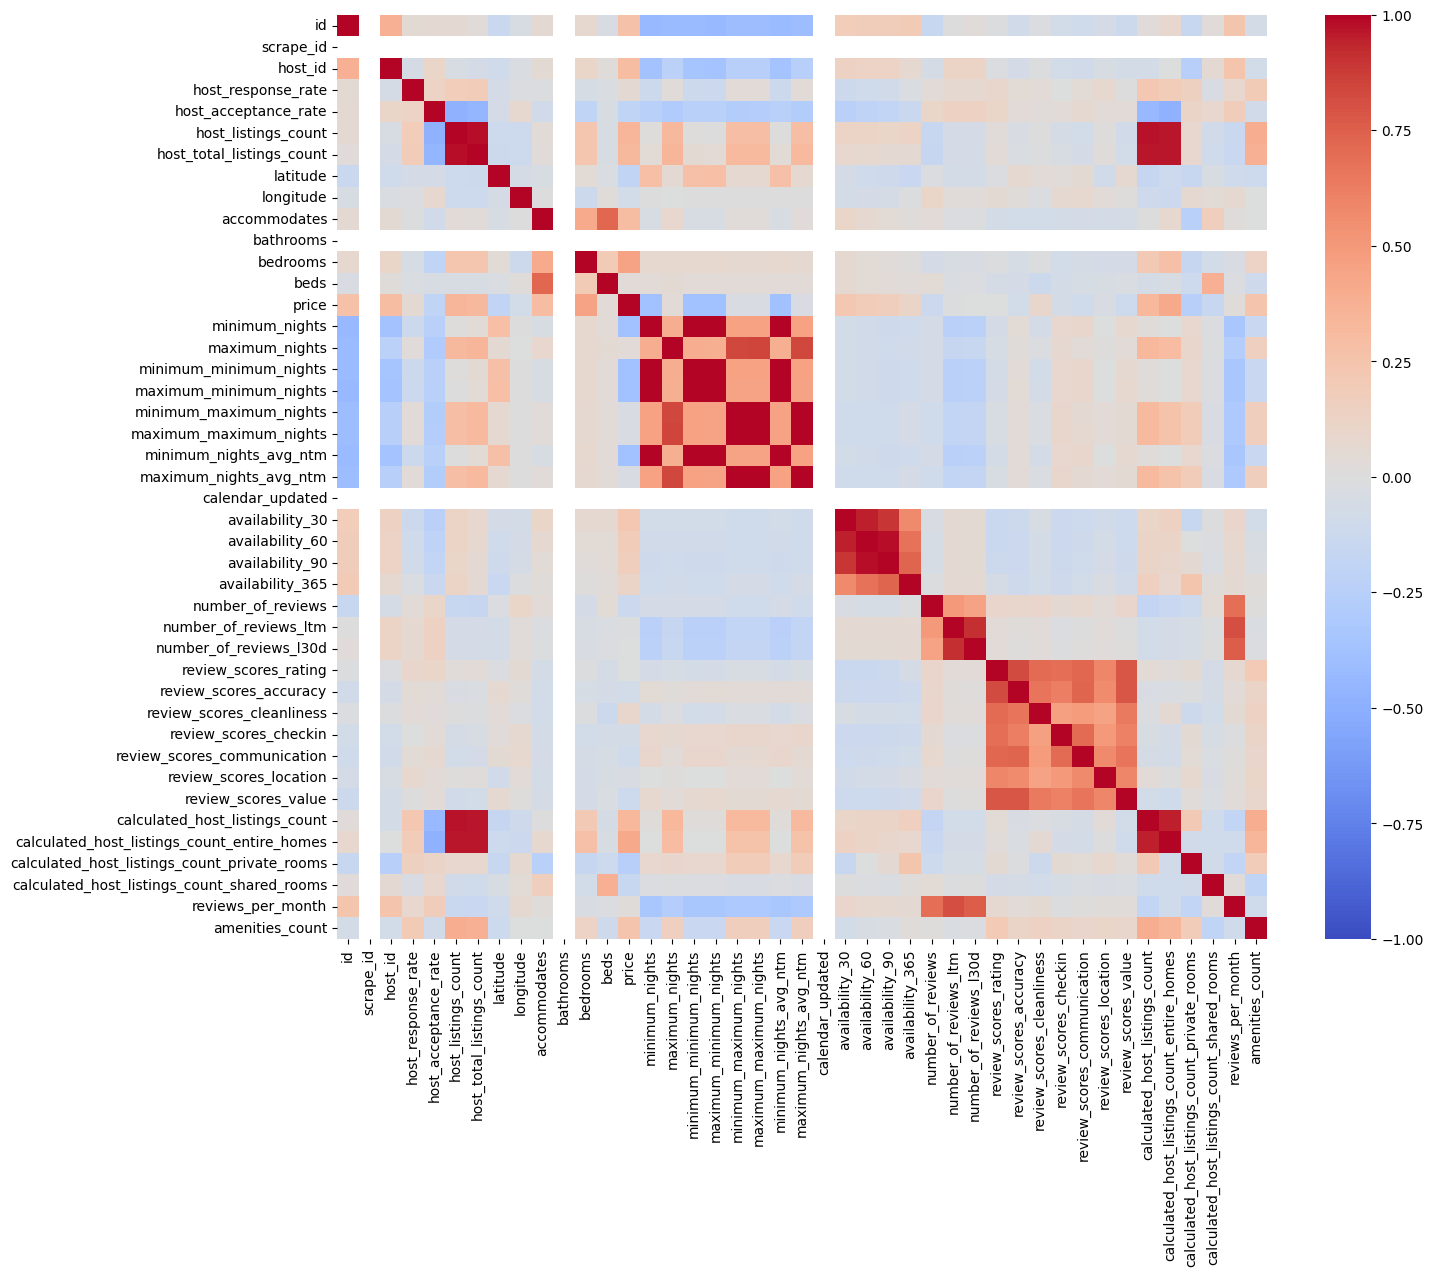

In [10]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=False, cmap='coolwarm', xticklabels=corr_matrix.columns.values, yticklabels=corr_matrix.columns.values)
plt.show()

## Type conversion for categorical variables (one-hot encoding)

In [11]:
print(len(listings_removed_outliers))

2853


In [24]:
# List of categorical features to be one-hot encoded
categorical_features = ['host_response_time', 'host_is_superhost', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 
                        'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'property_type', 'room_type', 
                        'has_availability', 'instant_bookable']

# Perform one-hot encoding on categorical features
listings_intermediate = pd.get_dummies(listings_removed_outliers, columns=categorical_features, drop_first=True, dtype=int)

## Type conversion for nlp score (positive/negative string to numeric)

In [25]:
# define the list of columns to convert
cols_to_convert = ['name_score', 'description_score', 'neighborhood_overview_score', 'host_about_score', 'amenities_score']

# create a dictionary to map values to their replacements
value_map = {'POSITIVE': 1, 'NEGATIVE': 0}

# use replace() method to replace the values in the specified columns
listings_final[cols_to_convert] = listings_intermediate[cols_to_convert].replace(value_map)

## Corr Matrix 2 (for Numeric AND Categorical Variables)

In [28]:
# for col in listings_final.columns:
#     print(f"{col}: {listings_final[col].dtype}")

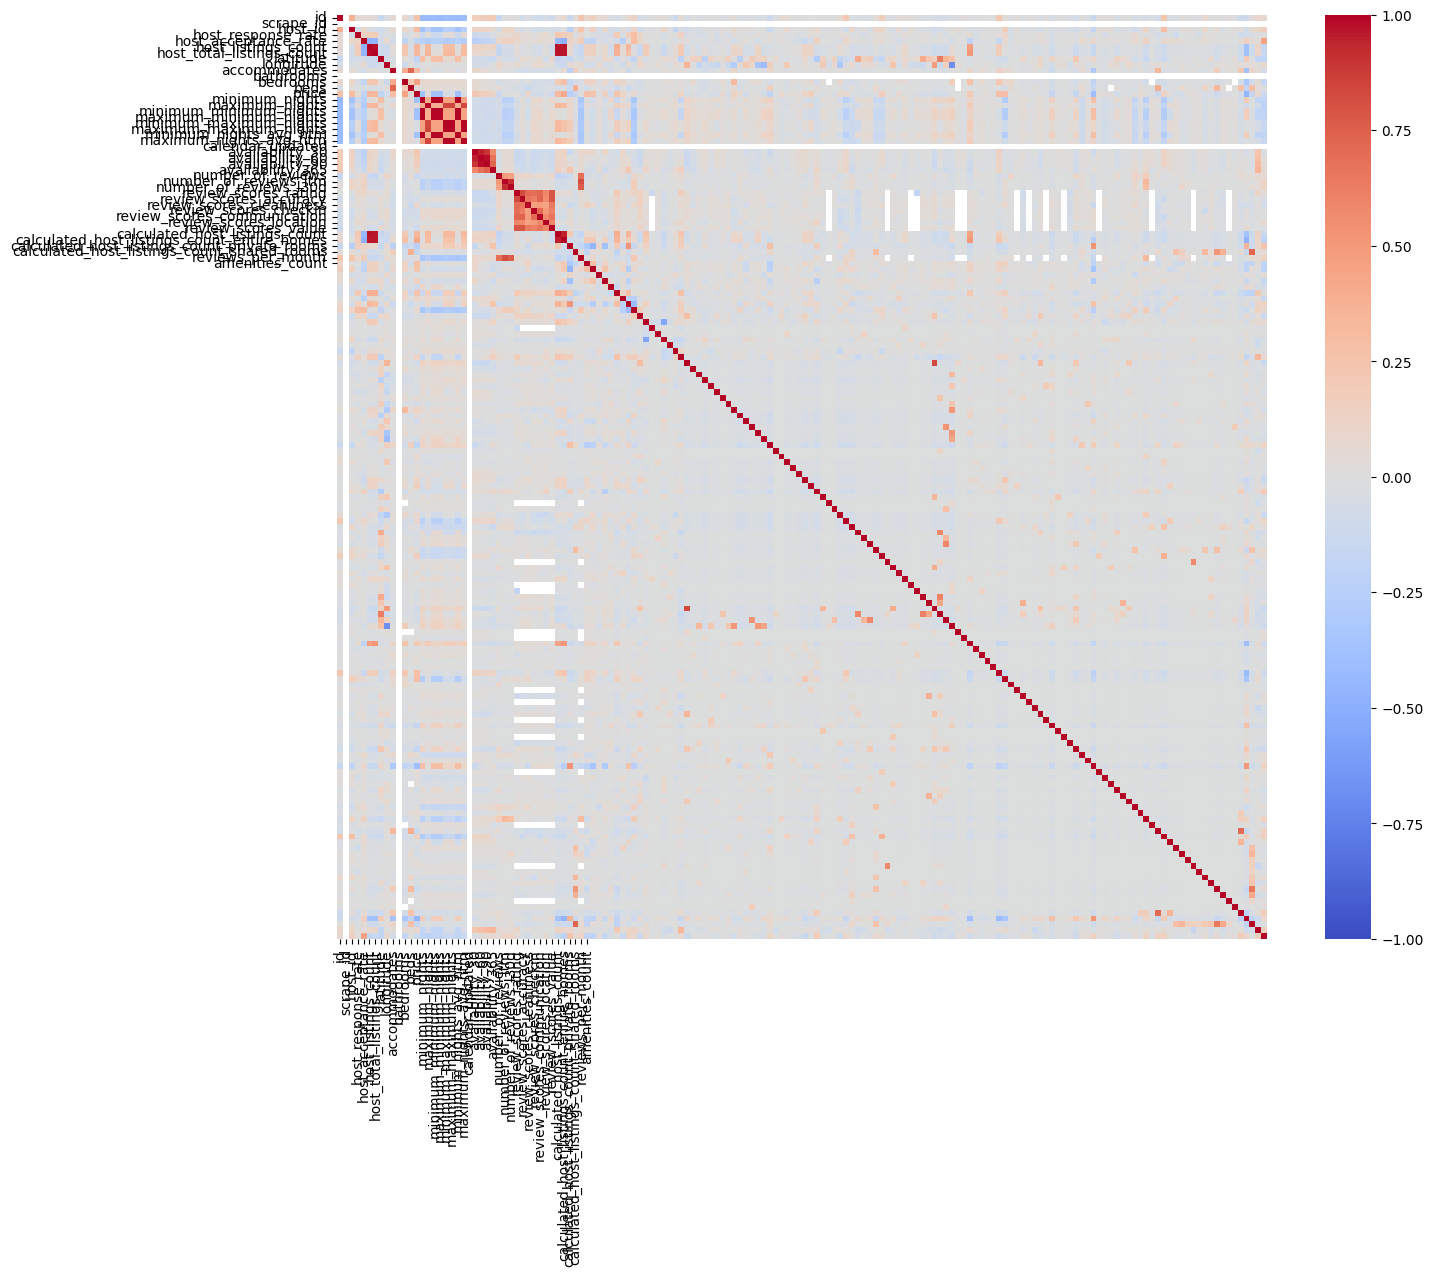

In [29]:
numeric_cols_final = listings_final.select_dtypes(include=['float64', 'int64']).columns
corr_matrix_final = listings_final[numeric_cols_final].corr()
price_corr_abs_final = corr_matrix_final['price'].abs().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(corr_matrix_final, vmin=-1, vmax=1, annot=False, cmap='coolwarm', xticklabels=corr_matrix.columns.values, yticklabels=corr_matrix.columns.values)
plt.show()

In [31]:
# print the top 8 correlations for price based on absolute values
print("Top 20 correlations for 'price' based on absolute values:")
print(price_corr_abs_final[1:21])

Top 20 correlations for 'price' based on absolute values:
bedrooms                                        0.451534
room_type_Private room                          0.447611
calculated_host_listings_count_entire_homes     0.417586
property_type_Private room in rental unit       0.399308
minimum_nights                                  0.380008
maximum_minimum_nights                          0.379487
minimum_nights_avg_ntm                          0.377291
minimum_minimum_nights                          0.375274
host_listings_count                             0.350427
calculated_host_listings_count                  0.328172
host_total_listings_count                       0.321340
host_id                                         0.301036
accommodates                                    0.299032
property_type_Entire serviced apartment         0.290531
property_type_Entire rental unit                0.289546
name_score                                      0.272948
id                            

## Write Output

In [32]:
listings_final.to_csv('datasets/listings_preprocessed.csv', index=False)